In [1]:
# dependencies

import numpy as np
import pandas as pd

import xfx.lm.gibbs
import xfx.misc.plot

In [2]:
# helper functions

def package_samples(samples, factor_names):

    rfx_samples, prec_samples, disp_samples = zip(*samples)
    rfx_samples = [np.array(samples_) for samples_ in zip(*rfx_samples)]
    prec_samples = np.array(prec_samples)
    disp_samples = np.array(disp_samples)
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names), package_prec_samples(prec_samples, factor_names), pd.DataFrame(disp_samples).T.rename_axis(columns='iter')

def package_rfx_samples(rfx_samples, factor_names):

    dfs = []
    for samples_, factor_name in zip(rfx_samples, factor_names):
        df_ = pd.DataFrame(samples_.T)
        df_.index = df_.index.rename('level')
        df_.columns = df_.columns.rename('iter')
        df_['factor'] = factor_name
        dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['factor', 'level'])
    return df

def package_prec_samples(prec_samples, factor_names):

    df = pd.DataFrame(prec_samples.T, index=factor_names)
    df.index = df.index.rename('factor')
    df.columns = df.columns.rename('iter')
    return df

In [3]:
# select predictors

factor_names = ['s', 'd', 'studage', 'lectage', 'service', 'dept']

In [4]:
# configure algorithm (hyperprior on the random effect prior precision is Wishart(prior_pseudo_tau, prior_guess_tau / prior_pseudo_tau))

n_samples = 1000
n_warmup = 100
prior_pseudo_tau = np.ones(len(factor_names))
prior_guess_tau = np.ones(len(factor_names))
seed = 0

In [5]:
# create inputs

insteval = pd.read_csv('demos/data/insteval.csv').loc[:, factor_names + ['y']]
n_obs = np.ones(len(insteval.y))
sum_obs = insteval.y
sumsq_obs = insteval.y ** 2
indices = insteval.reset_index().loc[:, factor_names].apply(lambda x: x.astype('category').cat.codes)
n_levels = indices.max(0).values + 1
rng = np.random.default_rng(seed)

In [6]:
# sample

sampler = xfx.lm.gibbs.sample_posterior(sum_obs.values, sumsq_obs.values, n_obs, n_levels, indices.values, prior_pseudo_tau, prior_guess_tau, ome=rng)
samples = [next(sampler) for _ in range(n_samples + n_warmup)][n_warmup:]

In [7]:
# reformat samples for plotting

rfx_samples, prec_samples, disp_samples = package_samples(samples, factor_names)

In [8]:
# random effects samples

rfx_samples.iloc[:5, :5]

iter                 0         1         2         3         4
factor level                                                  
_const 0      3.147627  3.650810  3.025762  3.721707  2.818754
s      0      0.378878  0.118039 -0.041523  0.321282  0.039203
       1      0.206502 -0.390341  0.137272 -0.367651 -0.366864
       2      0.799721  0.304317  0.379721  0.276420  0.345697
       3      0.158466  0.179849  0.177729  0.196612  0.265470

In [9]:
# prior precision samples

prec_samples.iloc[:5, :5]

iter,0,1,2,3,4
factor,,,,,
s,9.373590,9.577410,9.403949,9.252850,9.115398
d,3.820755,3.684135,3.855160,3.921960,3.837228
studage,1.224925,9.302770,5.556280,13.730592,1.489631
lectage,9.722581,2.666199,8.030792,2.678366,2.325460
service,4.460670,1.883158,7.598288,0.704584,1.439701


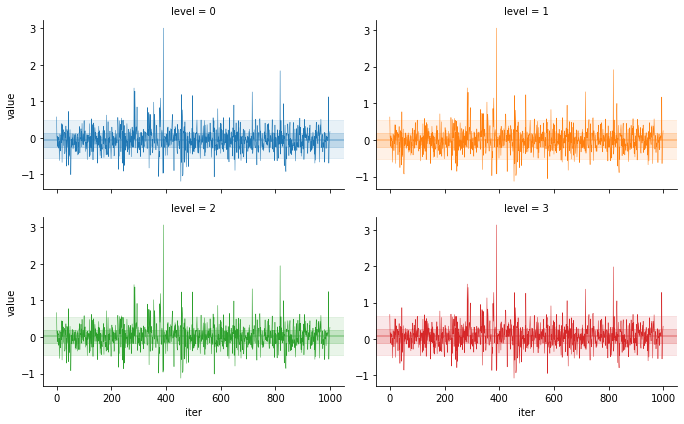

In [10]:
# plot traces for 'studage' random effects, grid and color by level

xfx.misc.plot.plot_traces(rfx_samples.loc['studage'], 'iter', 'level', 'level')

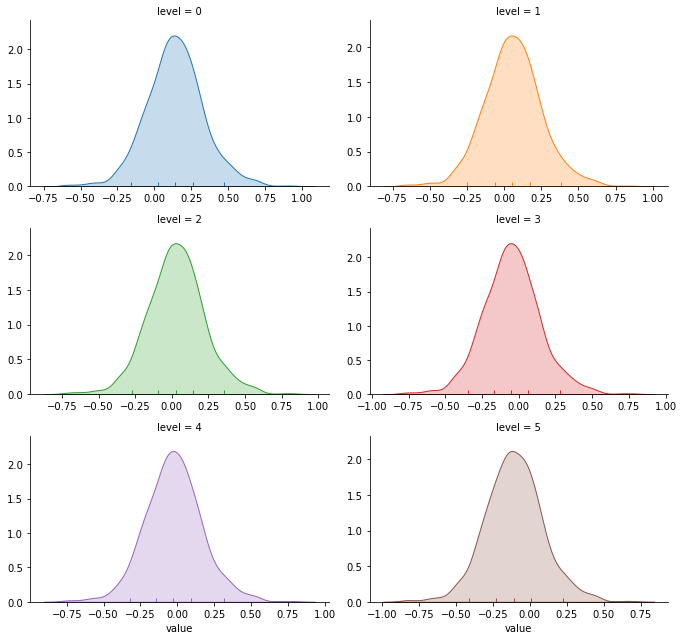

In [11]:
# plot marginals for 'lectage' random effects, grid and color by level

xfx.misc.plot.plot_marginals(rfx_samples.loc['lectage'], 'level', 'level')

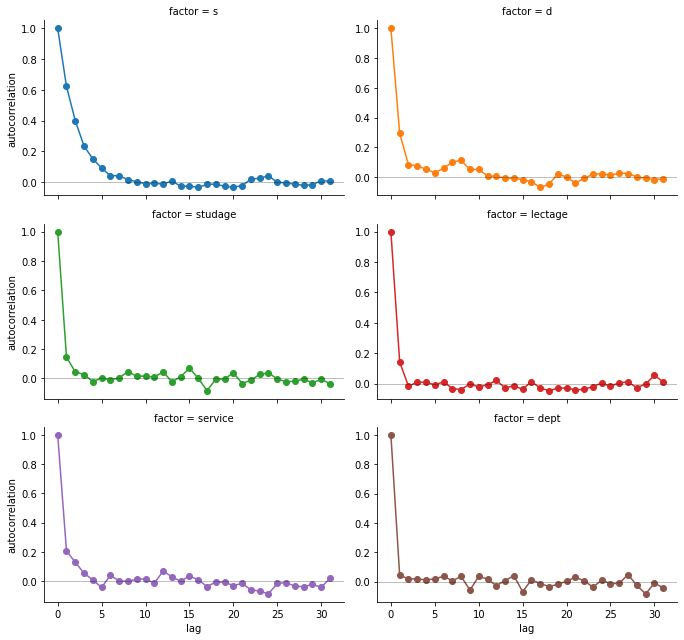

In [12]:
# plot ACFs for prior precisions, grid and color by level

xfx.misc.plot.plot_acf(prec_samples, 'factor', 'factor')